# Clustering Task


In [ ]:
# NOTES FOR ATREYA
# - careful, for train test split of single cell data patient 7 is the only person with 2 samples hence make sure to not use one sample from this person for 
# train and one for test -> will lead to overly optimistic results
# NOTE: we have labels BUT DO NOT TAKE supervised regression approach, the labels are only for cluster performance assessment
# - careful when submitting and zipping mac creates the MACOSX files in the zipped file !!!! -> this will not comply with the required
# submission format and hence lose us a submission, make sure you check this !!!
# - they provided some sanity checks in the reference code that is meant as a starting point, check those (listed directly below here for the clustering task)
# - zip everything up properly as described in the 
# - change my hardcoded data paths (hardcoded since at some point the relative paths started acting up)
# - use my zip file with the data since that one contains the data in a better structured format
# - dont forget the requirements file, also here some notes with respect to the installs:
# use python 3.10, numpy version 1.6.24 (latest one before numpy 2....), and then conda pip or fork install all the required libraries as you go 
# (you will see when running the cells)
# - if time extend the comments and fix the code a bit (but low priority)
# - remove this section
# - combine this with the other script to be able to zip up all the results of the two in one (see reference code)

# THINGS TO PLAY AROUND WITH AND IMPROVE
# - all the hyperparameters (e.g. number of principal components for PCA, cutoffs for outliers, ...)
# - another batching approach (e.g. combat instead of harmony), another clustering approach or new combinations of these
# -> recall that certain batching approaches work better with certain clusterings

In [2]:
print(f"Number of cells in the train set {train_adata.n_obs}")
for spl in train_adata.obs.Sample.unique():
    print(f"Number of cells for {spl} is {train_adata[train_adata.obs.Sample==spl].n_obs}")

NameError: name 'train_adata' is not defined

In [ ]:
print(f"There are {train_adata.obs.highLevelType.nunique()} different cell types in the dataset")
print(f"The different cells types are {train_adata.obs.highLevelType.unique().astype(str)}")

In [ ]:
print(f"Number of cells in the test set {test_adata.n_obs}")
for spl in test_adata.obs.Sample.unique():
    print(f"Number of cells for {spl} is {test_adata[test_adata.obs.Sample==spl].n_obs}")

In [2]:
import scanpy as sc
# import pandas as pd
# import numpy as np
from sklearn.metrics import adjusted_rand_score, v_measure_score
from sklearn.model_selection import train_test_split
import scanpy.external as sce

# reproducibility
seed = 999

In [3]:
# split training data to prevent leakage (since patient 7 two samples)

# Load training data
train_adata_path = '../data/cluster/train/train_adata.h5ad'
train_adata = sc.read_h5ad(train_adata_path)

# List of unique patients
patients = train_adata.obs['Patient'].unique()
print("Patients in training data:", patients)

# Split patients into training and validation sets
train_patients, val_patients = train_test_split(
    patients, test_size=0.3, random_state=seed
)

# Subset the data
train_subset = train_adata[train_adata.obs['Patient'].isin(train_patients)].copy()
validation_subset = train_adata[train_adata.obs['Patient'].isin(val_patients)].copy()

print("Training patients:", train_patients)
print("Validation patients:", val_patients)

Patients in training data: ['P1', 'P2', 'P3', 'P4', 'P7']
Categories (5, object): ['P1', 'P2', 'P3', 'P4', 'P7']
Training patients: ['P2', 'P7', 'P1']
Categories (5, object): ['P1', 'P2', 'P3', 'P4', 'P7']
Validation patients: ['P4', 'P3']
Categories (5, object): ['P1', 'P2', 'P3', 'P4', 'P7']


AnnData object with n_obs × n_vars = 14754 × 2000
    obs: 'Sample', 'Patient', 'Tumor status', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'highLevelType', 'chemo', 'validation_split', 'n_counts', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


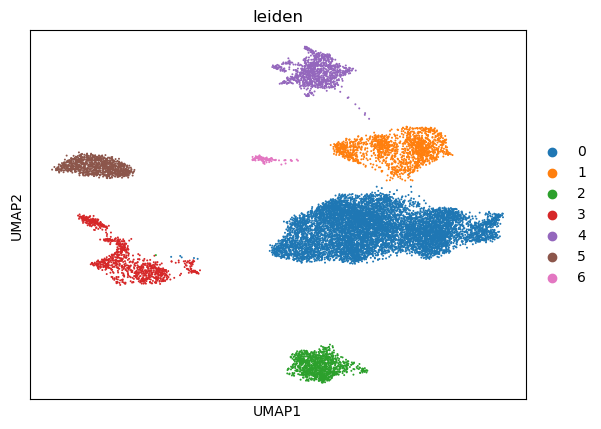

In [12]:
import matplotlib.pyplot as plt
# print(combined_train_adata.X.data.mean())
# print(combined_train_adata.X.data.std())
# print(combined_train_adata.X.data.max())
# print(combined_train_adata.X.data.min())
# plt.hist(np.log(combined_train_adata.X.data), bins=100)  # Histogram of values
# plt.title('Histogram of transformed data')
# plt.show()
print(combined_train_adata)
sc.tl.umap(combined_train_adata)
sc.pl.umap(combined_train_adata, color='leiden')
# sc.pl.violin(combined_train_adata, ['pct_counts_mt'], jitter=0.4)

In [4]:
# Combine training and validation subsets to ensure consistent preprocessing and batch correction
combined_train_adata = train_subset.concatenate(
    validation_subset,
    batch_key='validation_split',
    batch_categories=['train', 'validation'],
    index_unique=None
)

/var/folders/q9/hy2qr38d4tq0dl2xmk4ll2gc0000gn/T/ipykernel_6493/3985071899.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_train_adata = train_subset.concatenate(


In [5]:
# preprocess combined data
# - Mitochondrial gene expression is used as a quality metric because high levels may indicate cell stress or death
# - Cells with high mitochondrial content (>5%) are filtered out
# - Cells with extremely high total counts or gene numbers are also filtered to remove potential doublets (two cells captured as one)
# - Normalization adjusts for differences in sequencing depth across cells by scaling each cell's total counts to a common value (10,000)
# - Log Transformation stabilizes the variance across genes, making the data more suitable for downstream analysis


# quality control

# Don't need to identify mt genes as already done for us

# Identify mitochondrial genes
# combined_train_adata.var['mt'] = combined_train_adata.var_names.str.startswith('MT-')

# Calculate QC metrics
# sc.pp.calculate_qc_metrics(
#     combined_train_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True
# )

# Filter cells
combined_train_adata = combined_train_adata[combined_train_adata.obs.pct_counts_mt < 5, :]
sc.pp.filter_cells(combined_train_adata, max_counts=25000)
sc.pp.filter_cells(combined_train_adata, max_genes=6000)


# Normalization and Log Transformation

# Normalize total counts per cell
sc.pp.normalize_total(combined_train_adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(combined_train_adata)


# Highly Variable Genes (HVGs)

# Identify Highly Variable Genes (HVGs) using Seurat's method while accounting for batch effects
# NOTE: Highly Variable Genes are selected because they provide the most information for distinguishing between different cell types


# Identify HVGs
sc.pp.highly_variable_genes(
    combined_train_adata,
    flavor='seurat_v3',
    n_top_genes=2000,
    batch_key='Sample'
)

# Subset to HVGs
combined_train_adata = combined_train_adata[:, combined_train_adata.var.highly_variable]


# Scaling and PCA
# Perform PCA to reduce dimensionality
# WHY?: PCA simplifies scRNA-seq data by extracting key components, improving signal-to-noise ratio, 
# enabling effective batch correction and focusing clustering on biologically meaningful differences
# leading to more robustness of insights


# Scale the data
sc.pp.scale(combined_train_adata, max_value=10)

# Perform PCA
sc.tl.pca(combined_train_adata, svd_solver='arpack', n_comps=200)


# Batch Correction with Harmony
# NOTE: Harmony adjusts for batch effects in the PCA embeddings, preserving biological variability

# Run Harmony integration on PCA embeddings
sce.pp.harmony_integrate(combined_train_adata, key='Sample')

/opt/miniconda3/envs/ml4g-env-3/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:165: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number
/opt/miniconda3/envs/ml4g-env-3/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/opt/miniconda3/envs/ml4g-env-3/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2024-12-04 08:59:31,126 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-04 08:59:37,037 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-04 08:59:37,088 - harmonypy - INFO - Iteration 1 of 10
2024-12-04 08:59:40,487 - harmonypy - INFO - Iteration 2 of 10
2024-12-04 08:59:43,400 - harmonypy - INFO - Iteration 3 of 10
20

In [15]:
# Clustering on combined data
# - A k-Nearest Neighbors (KNN) graph is constructed using the Harmony-corrected PCA embeddings
# - graph represents the similarity between cells based on their gene expression profiles
# - Leiden Clustering detects communities (clusters) in the KNN graph


# Compute neighborhood graph
sc.pp.neighbors(combined_train_adata, n_neighbors=30, use_rep='X_pca_harmony')

# Cluster using Leiden algorithm
sc.tl.leiden(combined_train_adata, resolution=0.2)

In [16]:
# Evaluate Clustering Performance on Validation Set

# Split combined data back
train_indices = combined_train_adata.obs['validation_split'] == 'train'
val_indices = combined_train_adata.obs['validation_split'] == 'validation'

train_subset = combined_train_adata[train_indices].copy()
validation_subset = combined_train_adata[val_indices].copy()


# eval cluster performance

# True labels and predicted clusters for validation data
true_labels = validation_subset.obs['highLevelType']
pred_labels = validation_subset.obs['leiden']

# Compute ARI
ari = adjusted_rand_score(true_labels, pred_labels)
print(f"Validation Adjusted Rand Index (ARI): {ari:.4f}")

# Compute V-measure
v_measure = v_measure_score(true_labels, pred_labels)
print(f"Validation V-measure Score: {v_measure:.4f}")

# Combined metric
clustering_score = 0.5 * v_measure + 0.5 * ari
print(f"Validation Clustering Score: {clustering_score:.4f}")

Validation Adjusted Rand Index (ARI): 0.8410
Validation V-measure Score: 0.8282
Validation Clustering Score: 0.8346


In [74]:
true_labels

AAACCCACAAGCGAGT-1_3    Fibroblast
AAACGAAAGTGGTGAC-1_3             T
AAACGCTAGCGCATCC-1_3    Fibroblast
AAACGCTGTGTACATC-1_3             T
AAAGAACCACAAGCCC-1_3    Fibroblast
                           ...    
TTTGGTTGTCGTATTG-1_4             B
TTTGGTTTCAGAGCGA-1_4             T
TTTGTTGCACTTTAGG-1_4            NK
TTTGTTGCATCCGTGG-1_4             T
TTTGTTGTCCCTATTA-1_4             B
Name: highLevelType, Length: 3223, dtype: category
Categories (9, object): ['B', 'Endothelial', 'Fibroblast', 'Mast', ..., 'Myofibroblast', 'NK', 'Plasmablast', 'T']

In [ ]:
# PROCEED WITH TEST DATA CLUSTERING

# Load test data
test_adata = sc.read_h5ad('test_adata.h5ad')

# Combine training data and test data
combined_adata = train_adata.concatenate(
    test_adata,
    batch_key='dataset',
    batch_categories=['train', 'test'],
    index_unique=None
)

In [ ]:
# repeat preprocessing steps

# Quality control
# combined_adata.var['mt'] = combined_adata.var_names.str.startswith('MT-')
# sc.pp.calculate_qc_metrics(
#     combined_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True
# )
combined_adata = combined_adata[combined_adata.obs.pct_counts_mt < 4, :]
sc.pp.filter_cells(combined_adata, max_counts=25000)
sc.pp.filter_cells(combined_adata, max_genes=6000)

# Normalization and log transformation
sc.pp.normalize_total(combined_adata, target_sum=1e4)
sc.pp.log1p(combined_adata)

# HVGs
sc.pp.highly_variable_genes(
    combined_adata,
    flavor='seurat_v3',
    n_top_genes=2000,
    batch_key='Sample'
)
combined_adata = combined_adata[:, combined_adata.var.highly_variable]

# Scaling and PCA
sc.pp.scale(combined_adata, max_value=10)
sc.tl.pca(combined_adata, svd_solver='arpack', n_comps=50)

# Harmony integration
sce.pp.harmony_integrate(combined_adata, key='Sample')

# Clustering
sc.pp.neighbors(combined_adata, n_neighbors=30, use_rep='X_pca_harmony')
sc.tl.leiden(combined_adata, resolution=0.1)

In [ ]:
# save cluster assignments for test data

# CAREFUL WITH THE FORMATING
# NOTE TOO SURE IF BELOW WORKS FINE

# # Separate test data
# test_indices = combined_adata.obs['dataset'] == 'test'
# test_adata = combined_adata[test_indices].copy()

# # Prepare cluster membership DataFrame
# cluster_membership = pd.DataFrame({
#     'index': np.arange(len(test_adata)),
#     'cluster': test_adata.obs['leiden'].astype(int) + 1  # Ensure 1-indexed clusters
# })

# # Save to CSV
# cluster_membership.to_csv('cluster_membership.csv', index=False)
